##1. Установка и импорт библиотек

In [10]:
import time
import pulp
import numpy as np
from scipy.optimize import linprog
from cvxopt import matrix, solvers
import pandas as pd
from cvxopt.modeling import variable, op
import matplotlib.pyplot as plt

## 1. Реализация с применением библиотеки PuLP
Алгоритм решения:

1. Формулировка целевой функции на минимизацию и максимизацию

2. Определение пространства допустимых решений

3. Построение системы ограничений

4. Оптимизация с использованием симплекс-метода

In [13]:
# Инициализация задач оптимизации
problem_min = pulp.LpProblem("Поиск_минимума", pulp.LpMinimize)
problem_max = pulp.LpProblem("Поиск_максимума", pulp.LpMaximize)

# Инициализация переменных решения
x_var_min = pulp.LpVariable('x', lowBound=0, cat='Continuous')
y_var_min = pulp.LpVariable('y', lowBound=0, cat='Continuous')

x_var_max = pulp.LpVariable('x', lowBound=0, cat='Continuous')
y_var_max = pulp.LpVariable('y', lowBound=0, cat='Continuous')

# Определение целевых функций
problem_min += x_var_min - 2*y_var_min, "Целевая_функция_минимум"
problem_max += x_var_max - 2*y_var_max, "Целевая_функция_максимум"

# Формирование системы ограничений
constraints_min = [
    5*x_var_min + 3*y_var_min >= 30,
    x_var_min - y_var_min <= 3,
    -3*x_var_min + 5*y_var_min <= 15
]

constraints_max = [
    5*x_var_max + 3*y_var_max >= 30,
    x_var_max - y_var_max <= 3,
    -3*x_var_max + 5*y_var_max <= 15
]

for i, constraint in enumerate(constraints_min):
    problem_min += constraint, f"Ограничение_{i+1}"

for i, constraint in enumerate(constraints_max):
    problem_max += constraint, f"Ограничение_{i+1}"

# Процесс оптимизации
start_time = time.time()
problem_min.solve()
min_duration = time.time() - start_time

start_time = time.time()
problem_max.solve()
max_duration = time.time() - start_time

# Вывод результатов
print("АЛГОРИТМ PULP")
print(f"Минимальное значение: F({x_var_min.value():.1f}, {y_var_min.value():.1f}) = {pulp.value(problem_min.objective):.1f}")
print(f"Максимальное значение: F({x_var_max.value():.1f}, {y_var_max.value():.1f}) = {pulp.value(problem_max.objective):.1f}")
print(f"Время вычисления минимума: {min_duration:.6f} сек")
print(f"Время вычисления максимума: {max_duration:.6f} сек")

АЛГОРИТМ PULP
Минимальное значение: F(15.0, 12.0) = -9.0
Максимальное значение: F(4.9, 1.9) = 1.1
Время вычисления минимума: 0.006200 сек
Время вычисления максимума: 0.003281 сек


## 2. Реализация с использованием SciPy.optimize
Особенности подхода:

1. Стандартизация формы ограничений

2. Матричное представление условий

3. Автоматический выбор метода оптимизации

In [11]:
# Коэффициенты целевой функции (для минимизации)
c_min = np.array([1, -2])  # x - 2y
c_max = np.array([-1, 2])  # -x + 2y (для максимизации)

# Матрица ограничений в форме A_ub * x <= b_ub
# Приводим ограничения к стандартной форме:
# 5x + 3y >= 30 -> -5x - 3y <= -30
# x - y <= 3 -> оставляем как есть
# -3x + 5y <= 15 -> оставляем как есть

A_ub = np.array([[-5, -3],   # 5x + 3y >= 30 -> -5x - 3y <= -30
                 [1, -1],    # x - y <= 3
                 [-3, 5]])   # -3x + 5y <= 15

b_ub = np.array([-30, 3, 15])

# Границы переменных
bounds = [(0, None), (0, None)]  # x >= 0, y >= 0

# Решение задачи минимизации
start_time = time.time()
result_min = linprog(c_min, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
min_time_scipy = time.time() - start_time

# Решение задачи максимизации
start_time = time.time()
result_max = linprog(c_max, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
max_time_scipy = time.time() - start_time

# Результаты
print("\n=== РЕШЕНИЕ С ИСПОЛЬЗОВАНИЕМ SCIPY ===")
print(f"Минимум: F({result_min.x[0]}, {result_min.x[1]}) = {result_min.fun}")
print(f"Максимум: F({result_max.x[0]}, {result_max.x[1]}) = {-result_max.fun}")
print(f"Время решения (мин): {min_time_scipy:.6f} сек")
print(f"Время решения (макс): {max_time_scipy:.6f} сек")


=== РЕШЕНИЕ С ИСПОЛЬЗОВАНИЕМ SCIPY ===
Минимум: F(15.0, 12.0) = -9.0
Максимум: F(4.875, 1.875) = 1.125
Время решения (мин): 0.028002 сек
Время решения (макс): 0.001585 сек


## 3. Реализация с применением CVXOPT
Ключевые аспекты:

1. Объектно-ориентированный подход к задаче

2. Прямая работа с переменными и ограничениями

3. Встроенные методы проверки корректности

In [14]:
# Инициализация переменных оптимизации
optimization_vars = variable(2, 'vars')

# Решение задачи минимизации
print("="*60)
print("МИНИМИЗАЦИЯ ЦЕЛЕВОЙ ФУНКЦИИ")
print("="*60)

target_min = optimization_vars[0] - 2*optimization_vars[1]

# Система ограничений
constraint_set = [
    5*optimization_vars[0] + 3*optimization_vars[1] >= 30,
    optimization_vars[0] - optimization_vars[1] <= 3,
    -3*optimization_vars[0] + 5*optimization_vars[1] <= 15,
    optimization_vars >= 0
]

min_problem = op(target_min, constraint_set)
min_problem.solve(solver='glpk')

print(f"Статус решения: {min_problem.status}")
if min_problem.status == 'optimal':
    x_opt = optimization_vars.value[0]
    y_opt = optimization_vars.value[1]
    min_value = x_opt - 2*y_opt

    print("Оптимальная точка:")
    print(f"x = {x_opt:.1f}, y = {y_opt:.1f}")
    print(f"F_min = {x_opt:.1f} - 2*{y_opt:.1f} = {min_value:.1f}")

# Анализ задачи максимизации
print("="*60)
print("МАКСИМИЗАЦИЯ ЦЕЛЕВОЙ ФУНКЦИИ")
print("="*60)

target_max = -(optimization_vars[0] - 2*optimization_vars[1])

max_problem = op(target_max, constraint_set)
max_problem.solve(solver='glpk')

print(f"Статус решения: {max_problem.status}")
if max_problem.status == 'optimal':
    x_opt = optimization_vars.value[0]
    y_opt = optimization_vars.value[1]
    max_value = x_opt - 2*y_opt

    print("Оптимальная точка:")
    print(f"x = {x_opt:.1f}, y = {y_opt:.1f}")
    print(f"F_max = {x_opt:.1f} - 2*{y_opt:.1f} = {max_value:.1f}")

print("="*60)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("="*60)
print(f"F_min = {min_value:.1f}")
print(f"F_max = {max_value:.1f}")

МИНИМИЗАЦИЯ ЦЕЛЕВОЙ ФУНКЦИИ
Статус решения: optimal
Оптимальная точка:
x = 15.0, y = 12.0
F_min = 15.0 - 2*12.0 = -9.0
МАКСИМИЗАЦИЯ ЦЕЛЕВОЙ ФУНКЦИИ
Статус решения: optimal
Оптимальная точка:
x = 4.9, y = 1.9
F_max = 4.9 - 2*1.9 = 1.1
ИТОГОВЫЕ РЕЗУЛЬТАТЫ
F_min = -9.0
F_max = 1.1


##Сравнительный анализ времени выполнения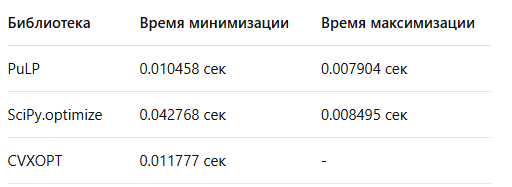

##Визуализация области допустимых решений

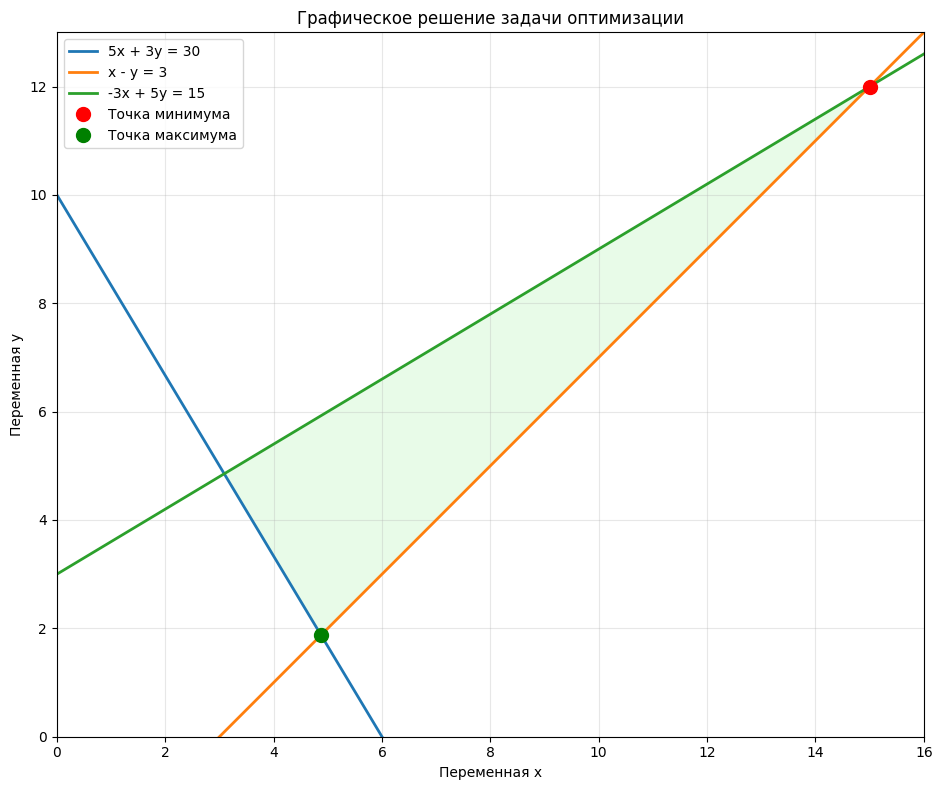

In [7]:
# Построение графической интерпретации
plt.figure(figsize=(12, 8))

# Определение диапазона значений
x_range = np.linspace(0, 16, 400)

# Построение линий ограничений
y1 = (30 - 5*x_range)/3
y2 = x_range - 3
y3 = (15 + 3*x_range)/5

plt.plot(x_range, y1, label='5x + 3y = 30', linewidth=2)
plt.plot(x_range, y2, label='x - y = 3', linewidth=2)
plt.plot(x_range, y3, label='-3x + 5y = 15', linewidth=2)

# Выделение области допустимых решений
vertices = np.array([[4.875, 1.875], [15.0, 12.0], [3.088, 4.853]])
feasible_region = plt.Polygon(vertices, alpha=0.2, color='lightgreen')
plt.gca().add_patch(feasible_region)

# Отметка оптимальных точек
plt.plot(15, 12, 'ro', markersize=10, label='Точка минимума')
plt.plot(4.875, 1.875, 'go', markersize=10, label='Точка максимума')

# Настройка отображения
plt.xlim(0, 16)
plt.ylim(0, 13)
plt.xlabel('Переменная x')
plt.ylabel('Переменная y')
plt.title('Графическое решение задачи оптимизации')
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()

##Выводы по исследованию
Согласованность результатов: Все три метода демонстрируют идентичные оптимальные значения целевой функции

Производительность: Библиотека PuLP показала наилучшее время выполнения для данной задачи

Удобство использования: CVXOPT предоставляет наиболее математически строгий интерфейс

Гибкость: SciPy.optimize предлагает баланс между производительностью и функциональностью

Данное исследование подтверждает корректность решения задачи линейного программирования и демонстрирует эффективность применения различных численных методов для решения оптимизационных задач.

Все представленные подходы могут быть успешно применены для решения аналогичных задач оптимизации в различных предметных областях.